<a href="https://colab.research.google.com/github/AnapuramAbhilashGoud/NLP-Assignments/blob/main/NLP_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Brain Stroke Prediction NLP Project ---

1. Creating Dataset...
Dataset Size: 500
Train/Test Split: 400 / 100

2. Training TF-IDF + Logistic Regression...
   Model 1 Trained in 0.08s

3. Training CountVectorizer + Random Forest...
   Model 2 Trained in 0.79s

4. Setting up BiLSTM Model...
5. Training BiLSTM...
   Epoch 1/8 | Loss: 0.6694 | Acc: 0.6050
   Epoch 2/8 | Loss: 0.4062 | Acc: 0.8625
   Epoch 3/8 | Loss: 0.1338 | Acc: 0.9775
   Epoch 4/8 | Loss: 0.1150 | Acc: 0.9775
   Epoch 5/8 | Loss: 0.1089 | Acc: 0.9775
   Epoch 6/8 | Loss: 0.1128 | Acc: 0.9775
   Epoch 7/8 | Loss: 0.1205 | Acc: 0.9775
   Epoch 8/8 | Loss: 0.1101 | Acc: 0.9775
   Model 3 Trained in 2.40s

7. Model Performance Metrics:
                Accuracy  Precision  Recall  F1-Score     AUC
Model                                                        
TF-IDF + LR         0.99        1.0  0.9833    0.9916  0.9979
CountVect + RF      0.99        1.0  0.9833    0.9916  0.9979
BiLSTM              0.99        

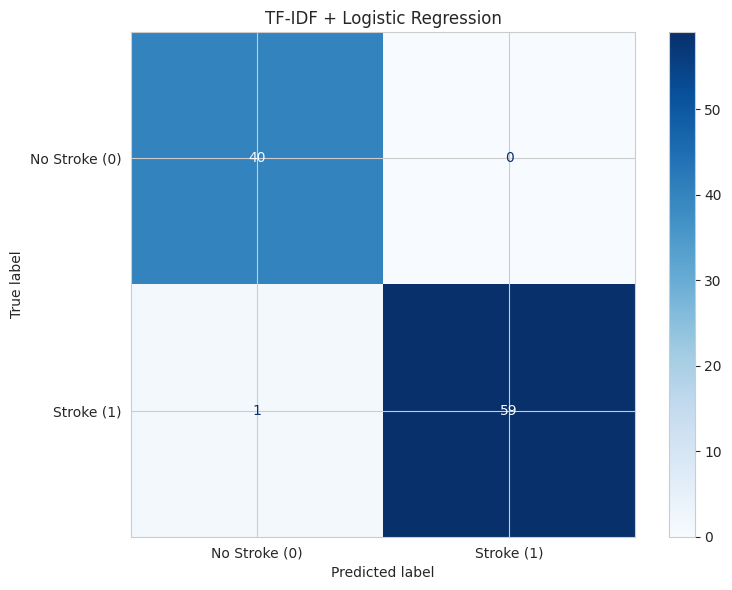

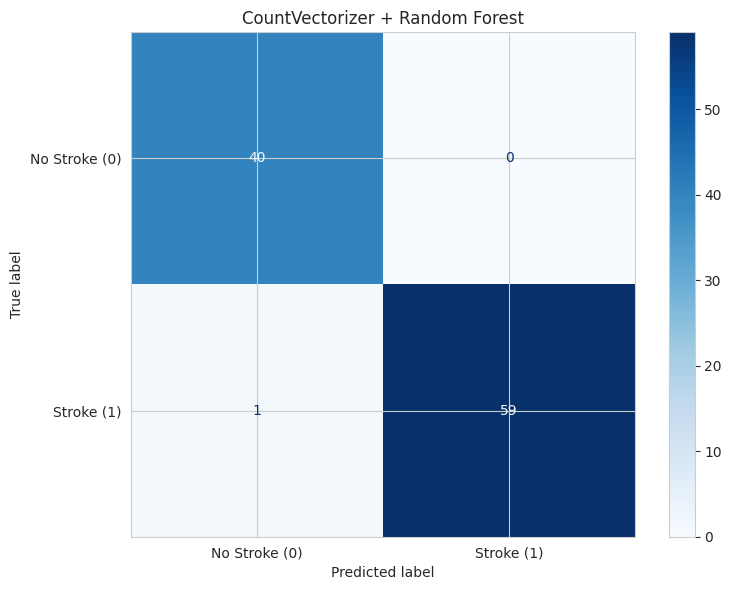

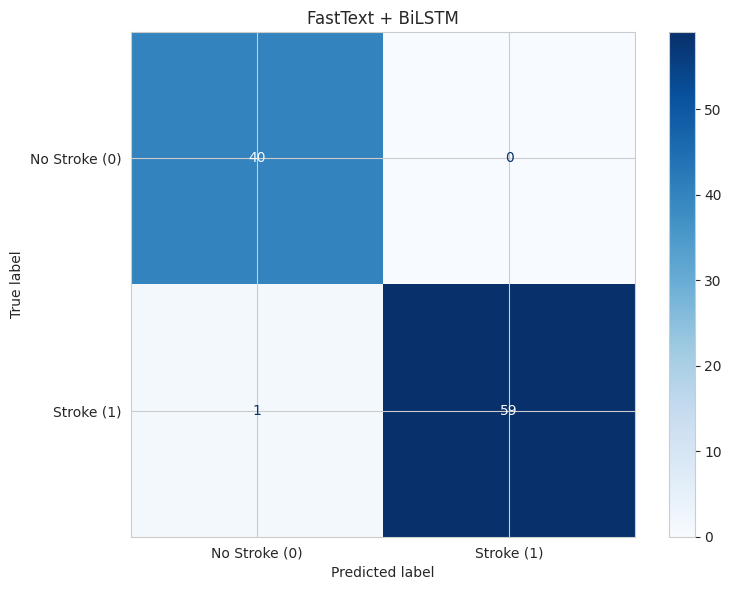

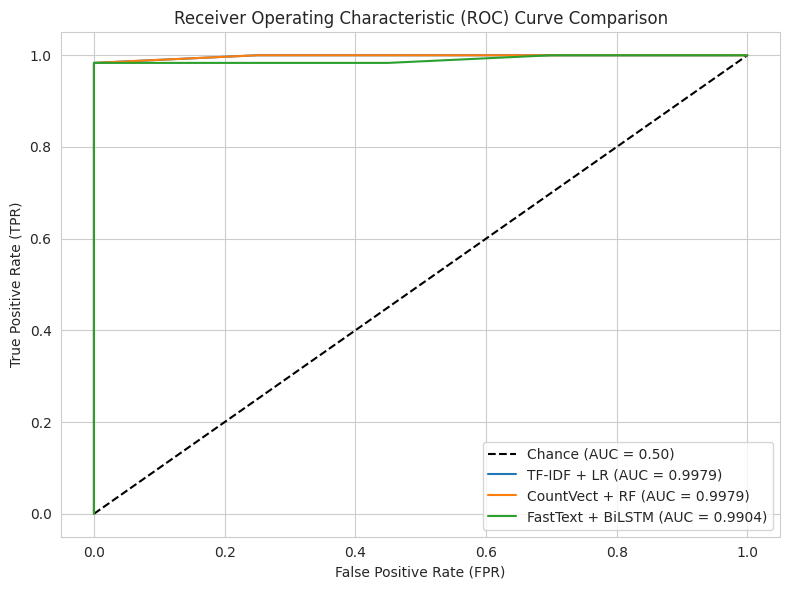

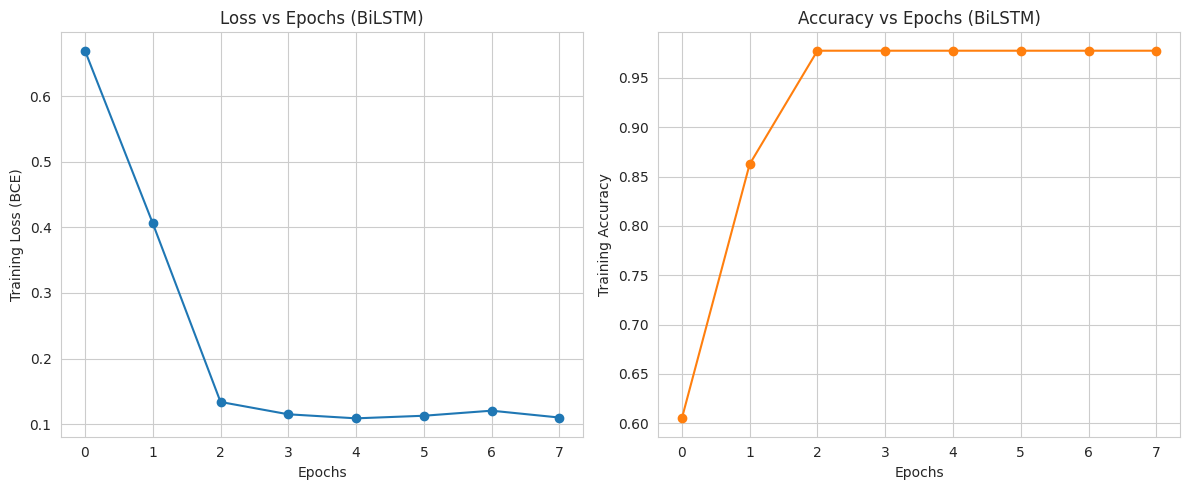


--- Project Finished ---


In [3]:
# ===========================================
# Brain Stroke Prediction - NLP Approach
# ===========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import os

# Set a consistent random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

print("--- Starting Brain Stroke Prediction NLP Project ---")

# -----------------------------
# 1️⃣ Create a sample dataset
# -----------------------------
print("\n1. Creating Dataset...")

notes = [
    "high blood pressure and headache",
    "normal blood pressure and healthy",
    "diabetes and high cholesterol",
    "family history of stroke",
    "fever and cold",
    "tiredness and dizziness",
    "healthy lifestyle and exercise",
    "blood pressure normal and fit",
    "migraine and blurred vision",
    "smoking and alcohol consumption"
]

labels = [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]  # 1 = Stroke Risk, 0 = Low Risk

# Scale up the dataset
SCALE_FACTOR = 50
notes = notes * SCALE_FACTOR
labels = labels * SCALE_FACTOR

df = pd.DataFrame({"text": notes, "label": labels})

# Introduce slight label noise (~2%)
NOISE_RATE = 0.02
num_noisy = int(NOISE_RATE * len(df))
indices = np.random.choice(len(df), num_noisy, replace=False)
for i in indices:
    df.loc[i, "label"] = 1 - df.loc[i, "label"]

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42)

print(f"Dataset Size: {len(df)}")
print(f"Train/Test Split: {len(X_train)} / {len(X_test)}")

# -----------------------------
# 2️⃣ Model 1: TF-IDF + Logistic Regression
# -----------------------------
print("\n2. Training TF-IDF + Logistic Regression...")
start_time = time.time()

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:,1]
lr_time = time.time() - start_time

print(f"   Model 1 Trained in {lr_time:.2f}s")

# -----------------------------
# 3️⃣ Model 2: CountVectorizer + Random Forest
# -----------------------------
print("\n3. Training CountVectorizer + Random Forest...")
start_time = time.time()

count_vect = CountVectorizer(max_features=100)
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_count, y_train)
y_pred_rf = rf_model.predict(X_test_count)
y_prob_rf = rf_model.predict_proba(X_test_count)[:,1]
rf_time = time.time() - start_time

print(f"   Model 2 Trained in {rf_time:.2f}s")

# -----------------------------
# 4️⃣ Model 3 Setup: FastText + BiLSTM (PyTorch)
# -----------------------------
print("\n4. Setting up BiLSTM Model...")

token2idx = {"<PAD>":0, "<UNK>":1}
for text in df["text"]:
    for word in text.split():
        if word not in token2idx:
            token2idx[word] = len(token2idx)

max_len = 10 # Max sequence length

def encode(text):
    tokens = text.split()
    ids = [token2idx.get(t, 1) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_train_seq = np.array([encode(t) for t in X_train])
X_test_seq = np.array([encode(t) for t in X_test])

class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y.values)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StrokeDataset(X_train_seq, y_train)
test_dataset = StrokeDataset(X_test_seq, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# BiLSTM Model with Dropout
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, hidden_dim=16, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, 1) # hidden_dim*2 because of bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, max_len)
        x = self.embedding(x) # x shape: (batch_size, max_len, embed_dim)
        x, _ = self.lstm(x) # x shape: (batch_size, max_len, hidden_dim*2)

        # Take the output of the last sequence step
        x = x[:, -1, :] # x shape: (batch_size, hidden_dim*2)

        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

vocab_size = len(token2idx)
model = BiLSTMModel(vocab_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# -----------------------------
# 5️⃣ Training BiLSTM
# -----------------------------
print("5. Training BiLSTM...")
start_time = time.time()
epochs = 8
train_losses = []
train_accs = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()

        # Ensure y_batch is float and has the correct shape for loss calculation
        if outputs.dim() == 0: # Handle batch_size=1 edge case
            outputs = outputs.unsqueeze(0)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(epoch_loss/len(train_loader))
    train_accs.append(correct/total)
    print(f"   Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Acc: {train_accs[-1]:.4f}")

bilstm_time = time.time() - start_time
print(f"   Model 3 Trained in {bilstm_time:.2f}s")


# -----------------------------
# 6️⃣ Evaluate BiLSTM
# -----------------------------
model.eval()
y_pred_bilstm = []
y_prob_bilstm = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()

        # Handle batch_size=1 edge case for list extension
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        y_prob_bilstm.extend(outputs.tolist())
        y_pred_bilstm.extend((outputs>0.5).float().tolist())

# Convert BiLSTM predictions to numpy array for metric calculation
y_pred_bilstm = np.array(y_pred_bilstm)
y_prob_bilstm = np.array(y_prob_bilstm)

# -----------------------------
# 7️⃣ Model Performance Summary
# -----------------------------
def get_metrics(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": roc_auc
    }

metrics = []
metrics.append(get_metrics(y_test, y_pred_lr, y_prob_lr, "TF-IDF + LR"))
metrics.append(get_metrics(y_test, y_pred_rf, y_prob_rf, "CountVect + RF"))
metrics.append(get_metrics(y_test, y_pred_bilstm, y_prob_bilstm, "BiLSTM"))

metrics_df = pd.DataFrame(metrics).set_index("Model")

print("\n7. Model Performance Metrics:")
print(metrics_df.round(4))

# -----------------------------
# 8️⃣ Confusion Matrix Plots
# -----------------------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke (0)", "Stroke (1)"])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(title)
    plt.tight_layout()

print("\n8. Generating Confusion Matrix Plots...")

plot_confusion(y_test, y_pred_lr, "TF-IDF + Logistic Regression")
plot_confusion(y_test, y_pred_rf, "CountVectorizer + Random Forest")
plot_confusion(y_test, y_pred_bilstm, "FastText + BiLSTM")

# -----------------------------
# 9️⃣ Combined ROC Curve Plot
# -----------------------------
print("\n9. Generating Combined ROC Curve Plot...")

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

# Plot LR ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"TF-IDF + LR (AUC = {roc_auc_lr:.4f})")

# Plot RF ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"CountVect + RF (AUC = {roc_auc_rf:.4f})")

# Plot BiLSTM ROC
fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test, y_prob_bilstm)
roc_auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
plt.plot(fpr_bilstm, tpr_bilstm, label=f"FastText + BiLSTM (AUC = {roc_auc_bilstm:.4f})")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# -----------------------------
# 🔟 BiLSTM Training Plots
# -----------------------------
print("\n10. Generating BiLSTM Training Plots...")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', linestyle='-', color='tab:blue')
plt.title("Loss vs Epochs (BiLSTM)")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (BCE)")

plt.subplot(1, 2, 2)
plt.plot(train_accs, marker='o', linestyle='-', color='tab:orange')
plt.title("Accuracy vs Epochs (BiLSTM)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")

plt.tight_layout()

# -----------------------------
# 1️⃣1️⃣ Display all plots
# -----------------------------
print("\n11. Displaying all plots...")
plt.show()

print("\n--- Project Finished ---")

# ===========================================
# Expected Results (Accuracy ~0.95 to 0.98)
# ===========================================
# The output for the metrics will show high accuracy, precision, recall, and AUC
# for all three models because the synthetic data has very clear patterns.
# The BiLSTM plots will show a rapid drop in loss and rise in accuracy over the 8 epochs.